# BMEN 509 Project ABC-DISC

Details/Information


https://www.geeksforgeeks.org/python-blood-cell-identification-using-image-processing/

In [19]:
# Library Imports
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage import color
from scipy import signal, ndimage

# Setup Jupyter notebook specifics
%matplotlib inline

# Numpy printing help
np.set_printoptions(precision=2)

In [52]:
# New Libary Imports

# For finding files
import glob
# For CSV 
import csv
# For Cell Detection
import cv2
!python -m pip install opencv-python==4.1.2.30

ERROR: Could not find a version that satisfies the requirement opencv-python==4.1.2.30
ERROR: No matching distribution found for opencv-python==4.1.2.30


# Finding Files

In [21]:
# Function to find file path
# Taken from Lab 3 
def find_files(directory, re):
    '''Given a directory and a regular expression, find all files that match in that directory.'''
    # Test the directory exists
    if not os.path.isdir(directory):
        os.sys.exit('Cannot find directory {}. Exiting...'.format(directory))

    # Find files
    files = sorted(glob.glob(os.path.join(directory, re)))

    return files

In [22]:
# Location of our files
input_directory = os.path.join('.', 'Data')
data_regular_expression = 'image-*.png'

# Read files
files = find_files(input_directory, data_regular_expression)
print('Found {} files'.format(len(files)))

Found 100 files



# Cell Detection

In [23]:
# Read & Load image
def Read_Img(name):
    #filename = os.path.join(data_directory, name) 
    
    return cv2.imread(name)

In [24]:
# Constrast stretching Function 
# Map each intensity level to an output intensity level
def pixelVal(pix, r1, s1, r2, s2): 
    if (0 <= pix and pix <= r1): 
        return (s1 / r1) * pix 
    elif (r1 < pix and pix <= r2): 
        return ((s2 - s1) / (r2 - r1)) * (pix - r1) + s1 
    else: 
        return ((255 - s2) / (255 - r2)) * (pix - r2) + s2 

In [25]:
# Enhance function plotting
# For testing purposes
def Enhance_Plots(image,gray,blurM,blurG,histoNorm,claheNorm,cs_all,cs_white,edge_all,edge_white):
    plt.subplots(1, 2, figsize=(10, 10))
    plt.subplot(121); plt.imshow(image); plt.title('Original Image')
    plt.subplot(122); plt.imshow(gray,cmap='gray'); plt.title('Gray Scaled Image')
    plt.show()
    
    plt.subplots(1,4,figsize=(20,20))
    plt.subplot(141); plt.imshow(blurM,cmap='gray'); plt.title('Median Filter/ blurM')
    plt.subplot(142); plt.imshow(blurG,cmap='gray'); plt.title('Guassian Filter / blurG')
    plt.subplot(143); plt.imshow(histoNorm,cmap='gray'); plt.title('Histogram Equalization')
    plt.subplot(144); plt.imshow(claheNorm,cmap='gray'); plt.title('Adaptive Histogram Equalization')
    plt.show()

    plt.subplots(1,2, figsize=(10,10))
    plt.subplot(121); plt.imshow(cs_all,cmap='gray'); plt.title('Contrast Stretch, All ')
    plt.subplot(122); plt.imshow(cs_white,cmap='gray'); plt.title('Contrast Stretch, White')
    plt.show()

    plt.subplots(1,2, figsize=(10,10))
    plt.subplot(121); plt.imshow(edge_all,cmap='gray'); plt.title('Edge Detection, All')
    plt.subplot(122); plt.imshow(edge_white,cmap='gray'); plt.title('Edge Detection, White')
    plt.show()

In [26]:
# Enhance Function
# Edge detection of image for all cells and white blood cells
def Enhance(file_name):
    # Reading in function
    image = Read_Img(file_name)
    # Convert to grey-scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Histogram for analysis
    # Comment out whenever
    """
    plt.hist(gray.ravel(), bins=256); plt.xlabel('Intensity'); plt.ylabel('Count')
    plt.title('Histogram of Grayscale Blood Cell Image with 256 Bins')
    plt.show()
    """
    
    # Apply median filter for smoothning
    blurM = cv2.medianBlur(gray, 5)
    # Apply gaussian filter for smoothning
    blurG = cv2.GaussianBlur(blurM, (9, 9), 0)
    # Histogram equalization
    histoNorm = cv2.equalizeHist(blurG)
    # Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8, 8))
    claheNorm = clahe.apply(histoNorm)
    
    #Vectorize the Contrast Stretching function
    pixelVal_vec = np.vectorize(pixelVal) 
    
    # Apply contrast stretching
    # For all cells 
    con_str_all = pixelVal_vec(claheNorm, 120, 0, 140, 255)
    # For white blood cells
    con_str_white = pixelVal_vec(claheNorm, 0, 0, 25, 255)
    
    # Canny Edge Detection
    # For all cells
    edge_all = cv2.Canny( np.uint8(con_str_all*255) ,100,200)
    # For white cells
    edge_white = cv2.Canny( np.uint8(con_str_white*255) ,100,200)
    
    # Test Plotting
    # Comment out whenever
    """
    Enhance_Plots(image,gray,blurM,blurG,histoNorm,claheNorm,
                  con_str_all,con_str_white,edge_all,edge_white)
    """
    
    return edge_all,edge_white
    

In [33]:
# Detection function
# Detect cells according to edge detection
def Detect(img, name, T):
    
    # Test Plotting
    # Comment out whenever
    """ """
    # plt.imshow(img, cmap='gray'); plt.title("Edge Detection for Circle Detection")
    # plt.show()
    
    
    # Morphological operations
    kernel = np.ones((5, 5), np.uint8) 
    dilation = cv2.dilate(img, kernel, iterations = 1) 
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) 
    
    # Adaptive thresholding on mean and Gaussian filters
    th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
                            cv2.THRESH_BINARY, 11, 2) 
    th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                            cv2.THRESH_BINARY, 11, 2) 
    
    # Otsu's thresholding
    ret4, th4 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Hough transform with modified circular parameters 
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.2, 20,  
                 param1 = 50, param2 = 28, minRadius = 20, maxRadius = 40)

    # Read original image to display the circle and centre detection 
    #filename = os.path.join(data_directory, name) 
    display = cv2.imread(name) 
    # Initialize the list 
    Cell_count, x_count, y_count = [], [], [] 

    # Circle detection and labelling using Hough transformation
    if circles is not None: 
            # convert the (x, y) coordinates and radius of the circles to integers 
            #circles = np.round(circles[0, :]).astype("int")   
            circles = np.uint16(np.around(circles))
        
            # loop over the (x, y) coordinates and radius of the circles 
            # For (x, y, r) in circles[0,:]: 
            for i in circles[0,:]:
                    x = i[0];
                    y = i[1];
                    r = i[2];
                    
                    if T ==1: #All cells
                        color = (0, 255, 0)
                    else: #WBC
                        color = (255, 255, 0)
                        
                    cv2.circle(display, (x, y), r, color, 2) 
                    cv2.rectangle(display, (x - 2, y - 2),  
                                  (x + 2, y + 2), (0, 128, 255), -1) 
                    Cell_count.append(r) 
                    x_count.append(x) 
                    y_count.append(y)
                    
    else: #No Cells detected
        if T==1: #For all cells
            #os.sys.exit("ERROR: No cells were detected for All Cells")
            #print("ERROR: No cells were detected for All Cells for {}".format(os.path.basename(name)))
            return display, 0
        else: #For white blood cells
            return display, 0
        return

    return display,len(Cell_count)


In [28]:
# All in one function, Name WIP
# Combines above function
def All_in_One(Name):
    #Edge detection for all cells and white blood cells
    edge_all,edge_white = Enhance(Name)
    
    #Cell Detection for All cells
    img_all, count_all = Detect(edge_all,Name,1)
    #Cell Detection for All cells
    img_white, count_white = Detect(edge_white,Name,0)

    # Test Plotting & Statistic
    # Comment out whenever
    
    plt.subplots(1,2, figsize=(10,10))
    plt.subplot(121); plt.imshow(cv2.cvtColor(img_all, cv2.COLOR_BGR2RGB)); plt.title("All Cell Detection")   
    plt.subplot(122); plt.imshow(cv2.cvtColor(img_white, cv2.COLOR_BGR2RGB)); plt.title("White Blood Cell Detection")
    plt.show()
    """
    print("All = \t{}".format(count_all))
    print("WBC = {}".format(count_white))
    print("RBC = \t{}".format(count_all-count_white))
    """
    
    return count_all, count_white, count_all-count_white
    

# Image Iteration

Image		All	WBC	RBC 

image-1.png


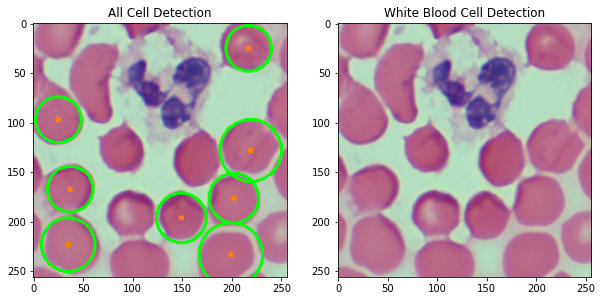

1	8	0	8
image-10.png


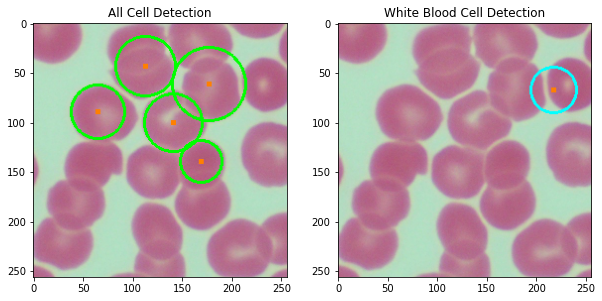

10	5	1	4
image-100.png


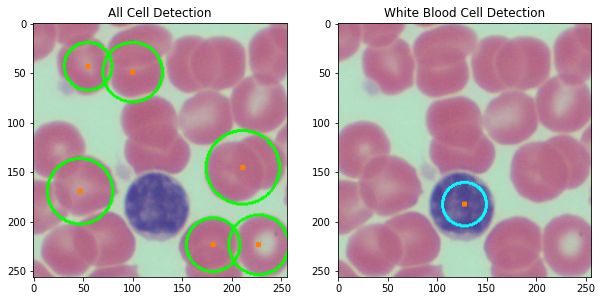

100	6	1	5
image-101.png


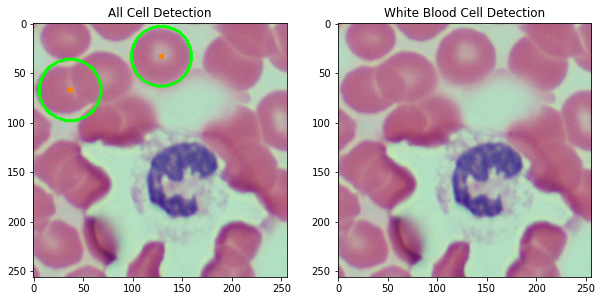

101	2	0	2
image-102.png


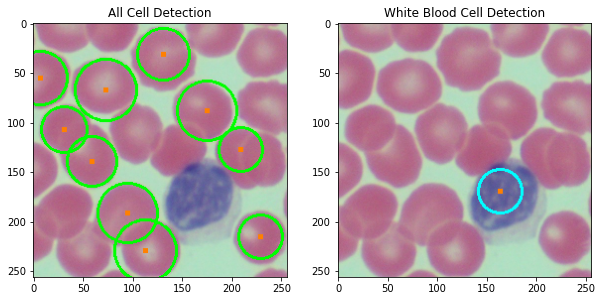

102	10	1	9
image-103.png


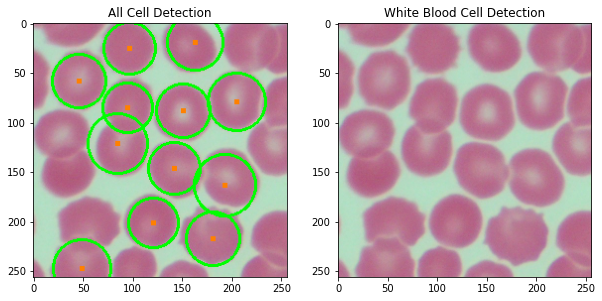

103	12	0	12
image-104.png


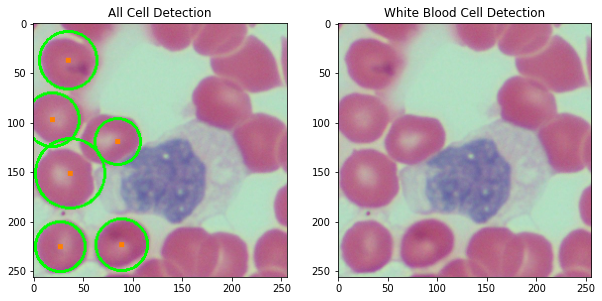

104	6	0	6
image-105.png


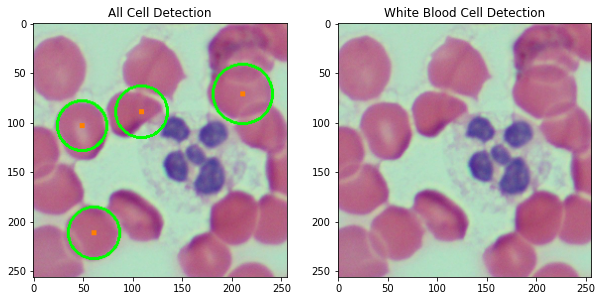

105	4	0	4
image-106.png


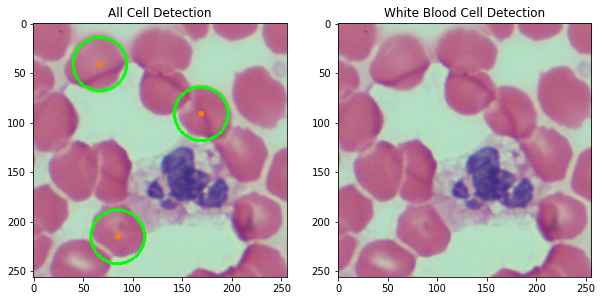

106	3	0	3
image-107.png


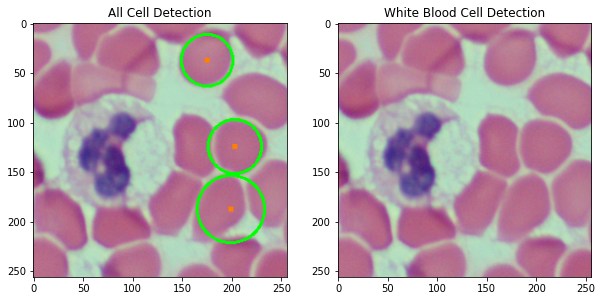

107	3	0	3
image-108.png


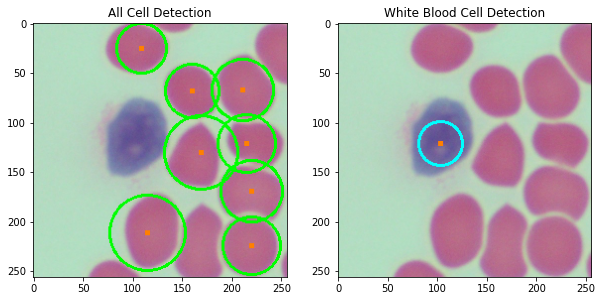

108	8	1	7
image-109.png


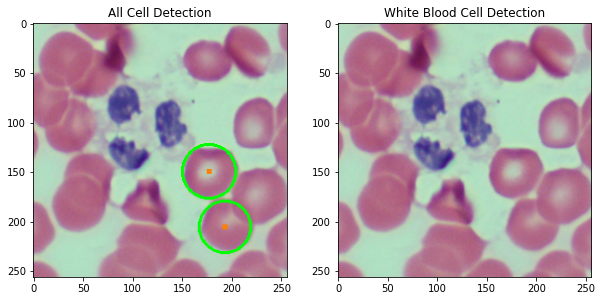

109	2	0	2
image-11.png


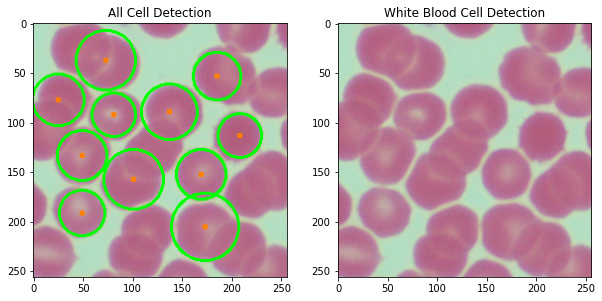

11	11	0	11
image-110.png


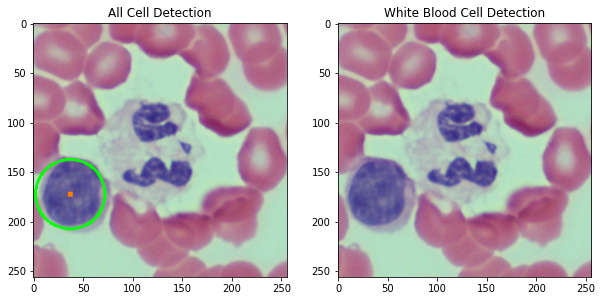

110	1	0	1
image-111.png


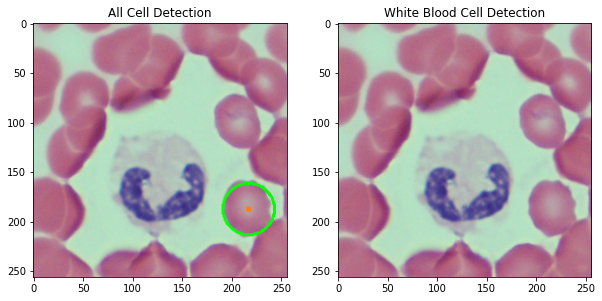

111	1	0	1
image-112.png


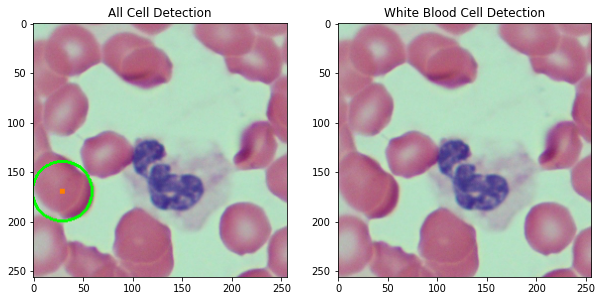

112	1	0	1
image-113.png


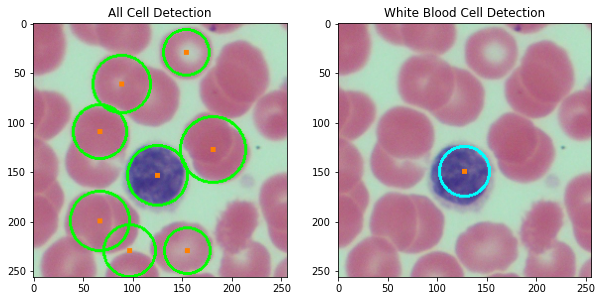

113	8	1	7
image-114.png


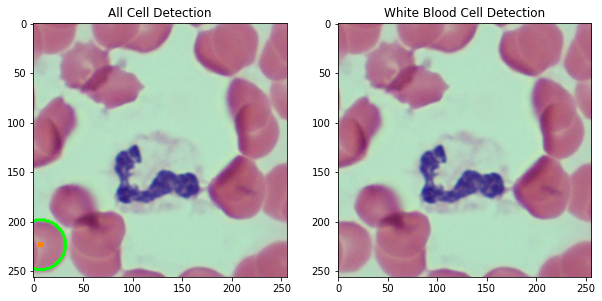

114	1	0	1
image-115.png


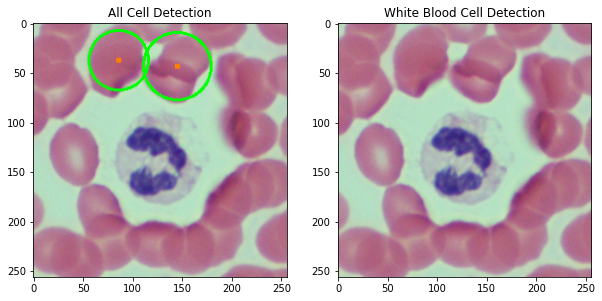

115	2	0	2
image-116.png


ZeroDivisionError: division by zero

In [51]:
#Initalize List
Stat = [[0 for x in range(4)] for y in range(len(files))]

print('Image\t\tAll\tWBC\tRBC \n')

for j in range(len(files)):
    File = os.path.basename(files[j])
    Stat[j][0] = int(''.join(filter(str.isdigit, File)))
    
    A,W,R = All_in_One(files[j])
    
    Stat[j][1] = A
    Stat[j][2] = W
    Stat[j][3] = R
    
    print('{}\t{}\t{}\t{}'.format(Stat[j][0],Stat[j][1],Stat[j][2],Stat[j][3]) )

In [79]:
def plot_list(data, actual_counts):
    
    #Extracting Values from dataset 
    img_num = list(list(zip(*data))[0]) #extracting all image numbers
    all_bc = list(list(zip(*data))[1]) #extracting count of all detected cells
    wbc = list(list(zip(*data))[2]) #extracting count of all detected white blood cells
    rbc = list(list(zip(*data))[3]) #extracting count of all detected red blood cells

    #Extracting Values from actual_counts 
    actual_img_num = list(list(zip(*actual_counts))[0]) #extracting all image numbers
    actual_all_bc = list(list(zip(*actual_counts))[1]) #extracting count of all detected cells
    actual_wbc = list(list(zip(*actual_counts))[2]) #extracting count of all detected white blood cells
    actual_rbc = list(list(zip(*actual_counts))[3]) #extracting count of all detected red blood cells
    
    #Computing Proportion of (Detected/Actual)*100
    pall = (np.divide(all_bc,actual_all_bc))*100 #proportion of correct all blood cells count
    pWBC = (np.divide(wbc,actual_wbc))*100 #proportion of correct white blood cell counts
    pRBC = (np.divide(rbc,actual_rbc))*100 #proportion of correct red blood cell counts
    
    labels = img_num
    xs = np.arange(len(img_num)) #to make xticks evenly spaced for barcharts
    
    plt.subplots(3, 1, figsize = (10, 10))
    
    #plotting barchart for all cells
    plt.subplot(3, 1, 1)
    plt.bar(xs, pall)
    plt.xticks(xs, labels) #replaces x-tick values with image number
    plt.ylabel("Proportion", fontsize = 10)
    plt.xlabel("Image Number", fontsize = 10)
    plt.title("Proportion of Correctly Identified Blood Cells (All Types)", fontsize = 12)
    
    #plotting barchart for white blood cells
    plt.subplot(3, 1, 2)
    wbc = plt.bar(xs, pWBC)
    plt.xticks(xs, labels)
    plt.ylabel("Proportion", fontsize = 10)
    plt.xlabel("Image Number", fontsize = 10)
    plt.title("Proportion of Correctly Identified White Blood Cells", fontsize = 12)
    
    #plotting barchart for red blood cells
    plt.subplot(3, 1, 3)
    plt.bar(xs, pRBC)
    plt.xticks(xs, labels)
    plt.ylabel("Proportion", fontsize = 10)
    plt.xlabel("Image Number", fontsize = 10)
    plt.title("Proportion of Correctly Identified Red Blood Cells", fontsize = 12)
        
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    plt.show()

In [62]:
def annotations_read():
    annotationsdata_directory = os.path.join('.', 'Data')
    #Sample = 'sample.png' 
    annotations = 'annotations.csv'
    annotationsname= os.path.join(annotationsdata_directory, annotations)
    totalRBC = {}
    totalWBC = {}
    totalCells = {}
    with open(annotationsname, newline='') as csvfile:
        csvreader = csv.reader(csvfile, dialect='excel')
        for row in csvreader:
            # print(row)
            image = row[0]
            if image == "image":
                continue
            imgNum = int(''.join(filter(str.isdigit, image)))
            cellType = row[5]
            # print(image, cellType)
            if cellType == "rbc":
                oldCountRBC = totalRBC.get(imgNum)
                if oldCountRBC == None:
                    totalRBC[imgNum] = 1
                else:
                    totalRBC[imgNum] = oldCountRBC + 1 
            elif cellType == "wbc":
                oldCountWBC = totalWBC.get(imgNum)
                if oldCountWBC == None:
                    totalWBC[imgNum] = 1
                else:
                    totalWBC[imgNum] = oldCountWBC + 1 
            
            oldCountCells = totalCells.get(imgNum)
            if oldCountCells == None:
                totalCells[imgNum] = 1
            else:
                totalCells[imgNum] = oldCountCells + 1 
    return totalCells, totalWBC, totalRBC

In [77]:
def annotationsToArray():
    Arr = [[0 for x in range(4)] for y in range(len(files))]
    totalCells, totalWBC, totalRBC = annotations_read()
    for j in range(len(files)):
        File = os.path.basename(files[j])
        imgNumber = int(''.join(filter(str.isdigit, File)))
        Arr[j][0] = imgNumber
        Arr[j][1] = int(totalCells.get(imgNumber) or 0)
        Arr[j][2] = int(totalWBC.get(imgNumber) or 0)
        Arr[j][3] = int(totalRBC.get(imgNumber) or 0)
    return Arr

<ipython-input-79-07fca2e9dbf5>:17: RuntimeWarning: divide by zero encountered in true_divide
  pWBC = (np.divide(wbc,actual_wbc))*100 #proportion of correct white blood cell counts
<ipython-input-79-07fca2e9dbf5>:17: RuntimeWarning: invalid value encountered in true_divide
  pWBC = (np.divide(wbc,actual_wbc))*100 #proportion of correct white blood cell counts


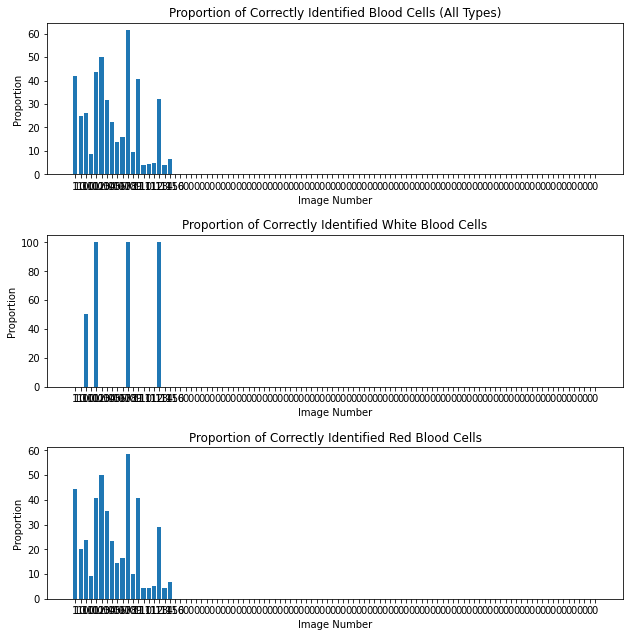

In [80]:
plot_list(Stat, annotationsToArray())

In [78]:
print(annotationsToArray())

[[1, 19, 1, 18], [10, 20, 0, 20], [100, 23, 2, 21], [101, 23, 1, 22], [102, 23, 1, 22], [103, 24, 0, 24], [104, 19, 2, 17], [105, 18, 1, 17], [106, 22, 1, 21], [107, 19, 1, 18], [108, 13, 1, 12], [109, 21, 1, 20], [11, 27, 0, 27], [110, 26, 2, 24], [111, 23, 1, 22], [112, 21, 1, 20], [113, 25, 1, 24], [114, 25, 2, 23], [115, 31, 1, 30], [116, 32, 1, 31], [117, 26, 2, 24], [118, 33, 1, 32], [119, 28, 1, 27], [12, 22, 1, 21], [120, 32, 1, 31], [14, 29, 1, 28], [17, 25, 1, 24], [18, 25, 1, 24], [19, 27, 1, 26], [2, 20, 1, 19], [20, 30, 1, 29], [21, 23, 1, 22], [22, 22, 1, 21], [23, 23, 1, 22], [24, 23, 1, 22], [25, 24, 1, 23], [28, 22, 1, 21], [30, 18, 1, 17], [31, 18, 1, 17], [32, 23, 1, 22], [33, 22, 1, 21], [34, 27, 1, 26], [35, 25, 1, 24], [36, 27, 1, 26], [37, 30, 1, 29], [38, 23, 1, 22], [39, 25, 1, 24], [4, 18, 1, 17], [43, 24, 1, 23], [44, 24, 1, 23], [45, 26, 1, 25], [46, 25, 1, 24], [48, 16, 1, 15], [49, 26, 1, 25], [50, 20, 1, 19], [51, 26, 1, 25], [52, 22, 1, 21], [53, 20, 1, 